# Dimensionality of the inputs to the filter

One of the main strengths of PyMC3 is its dependence on Theano. Theano allows to compute arithmetic operations on arbitrary tensors. This might not sound very impressive, but in the process:

* It can apply the chain rule to calculate the gradient of a scalar function on the unknown parameters
* Elementwise operations on tensors can be extended to any number of dimensions
* Smart optimizations on expressions are applied before compiling, reducing the computing time

Here, we will apply the Kalman filter to scalar observations and/or scalar state spaces. This will result in a noticeable speed improvement with respect to the general vector-vector case.

We will use the same example as in the previous notebook:

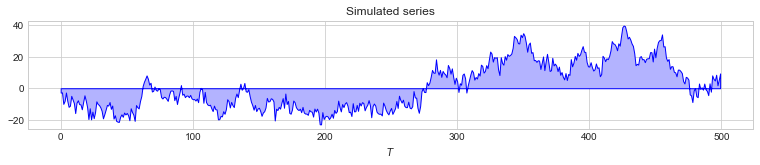

In [1]:
import numpy              as np
import theano
import theano.tensor      as tt
import kalman

import matplotlib.pyplot  as plt
import seaborn            as sns
sns.set_style("whitegrid")

%matplotlib inline

# True values
T = 500                 # Time steps
sigma2_eps0 = 3         # Variance of the observation noise
sigma2_eta0 = 10        # Variance in the update of the mean

# Simulate data
np.random.seed(12345)
eps = np.random.normal(scale=sigma2_eps0**0.5, size=T)
eta = np.random.normal(scale=sigma2_eta0**0.5, size=T)
mu = np.cumsum(eta)
y = mu + eps

# Plot the time series
fig, ax = plt.subplots(figsize=(13,2))
ax.fill_between(np.arange(T), 0, y, facecolor=(0.7,0.7,1), edgecolor=(0,0,1))
ax.set(xlabel='$T$', title='Simulated series');

#### Vectorial observation + vectorial state

In [2]:
# Measurement equation
Z, d, H = tt.dmatrix(name='Z'), tt.dvector(name='d'), tt.dmatrix(name='H')
# Transition equation
T, c, R, Q = tt.dmatrix(name='T'), tt.dvector(name='c'), \
             tt.dmatrix(name='R'), tt.dmatrix(name='Q')
# Tensors for the initial state mean and uncertainty
a0, P0 = tt.dvector(name='a0'), tt.dmatrix(name='P0')

# Values for the actual calculation
args = dict(Z = np.array([[1.]]), d = np.array([0.]), H = np.array([[3.]]),
            T = np.array([[1.]]), c = np.array([0.]), R = np.array([[1.]]),
            Q = np.array([[10.]]),
            a0 = np.array([0.]), P0 = np.array([[1e6]]))

# Create function to calculate log-likelihood
kalmanTheano = kalman.KalmanTheano(Z, d, H, T, c, R, Q, a0, P0)
(_,_,lliks),_ = kalmanTheano.filter(y[:,None])
f = theano.function([Z, d, H, T, c, R, Q, a0, P0], lliks[1:].sum())

# Evaluate
%timeit f(**args)

print('Log-likelihood:', f(**args))

11.9 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Log-likelihood: -1369.7346722999791


#### Scalar observation + vectorial state

In [3]:
# Measurement equation
Z, d, H = tt.dvector(name='Z'), tt.dscalar(name='d'), tt.dscalar(name='H')
# Transition equation
T, c, R, Q = tt.dmatrix(name='T'), tt.dvector(name='c'), \
             tt.dmatrix(name='R'), tt.dmatrix(name='Q')
# Tensors for the initial state mean and uncertainty
a0, P0 = tt.dvector(name='a0'), tt.dmatrix(name='P0')

# Values for the actual calculation
args = dict(Z = np.array([1.]), d = np.array(0.), H = np.array(3.),
            T = np.array([[1.]]), c = np.array([0.]), R = np.array([[1.]]),
            Q = np.array([[10.]]),
            a0 = np.array([0.]), P0 = np.array([[1e6]]))

# Create function to calculate log-likelihood
kalmanTheano = kalman.KalmanTheano(Z, d, H, T, c, R, Q, a0, P0)
(_,_,lliks),_ = kalmanTheano.filter(y)
f = theano.function([Z, d, H, T, c, R, Q, a0, P0], lliks[1:].sum())

# Evaluate
%timeit f(**args)

print('Log-likelihood:', f(**args))

11.8 ms ± 224 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Log-likelihood: -1369.7346722999757


#### Scalar observation + scalar state

In [4]:
# Measurement equation
Z, d, H = tt.dscalar(name='Z'), tt.dscalar(name='d'), tt.dscalar(name='H')
# Transition equation
T, c, R, Q = tt.dscalar(name='T'), tt.dscalar(name='c'), \
             tt.dscalar(name='R'), tt.dscalar(name='Q')
# Tensors for the initial state mean and uncertainty
a0, P0 = tt.dscalar(name='a0'), tt.dscalar(name='P0')

# Values for the actual calculation
args = dict(Z = np.array(1.), d = np.array(0.), H = np.array(3.),
            T = np.array(1.), c = np.array(0.), R = np.array(1.),
            Q = np.array(10.),
            a0 = np.array(0.), P0 = np.array(1e6))

# Create function to calculate log-likelihood
kalmanTheano = kalman.KalmanTheano(Z, d, H, T, c, R, Q, a0, P0)
(_,_,lliks),_ = kalmanTheano.filter(y)
f = theano.function([Z, d, H, T, c, R, Q, a0, P0], lliks[1:].sum())

# Evaluate
%timeit f(**args)

print('Log-likelihood:', f(**args))

4.93 ms ± 257 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Log-likelihood: -1369.7346722999757


The improvement in this case is clear. By profiling the operation, it becomes aparent that, for scalar inputs, the algebraic operations do not use BLAS routines, but just normal products.